# Simple iteration for systems of linear equations

First, generate a random diagonally dominant matrix, for testing.

In [12]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)

# I.  Jacobi iteration

Given

$$
A x = b
$$

separate the diagonal part $D$,

$$ A = D + (A - D) $$

and write

$$
x = D^{-1} (D - A) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = D^{-1} (D - A) \qquad \text{and} \qquad c = D^{-1} b
$$


Let's construct the matrix and the r.h.s. for the Jacobi iteration

In [13]:
diag_1d = np.diag(A)

B = -A.copy()
np.fill_diagonal(B, 0)

D = np.diag(diag_1d)

invD = np.diag(1./diag_1d)
BB = invD @ B
c = invD @ b

In [14]:
# sanity checks
from numpy.testing import assert_allclose

assert_allclose(-B + D, A)


# xx is a "ground truth" solution, compute it using a direct method
xx = np.linalg.solve(A, b)

np.testing.assert_allclose(A@xx, b)
np.testing.assert_allclose(D@xx, B@xx + b)
np.testing.assert_allclose(xx, BB@xx + c)

Check that $\| B\| \leqslant 1$:

In [15]:
np.linalg.norm(BB)

0.36436161983015336

### Do the Jacobi iteration

In [16]:
n_iter = 50

x0 = np.ones(n)
x = x0
for _ in range(n_iter):
    x = BB @ x + c

In [17]:
# Check the result:

A @ x - b

array([ 1.11022302e-16,  0.00000000e+00, -2.22044605e-16, -1.11022302e-16,
        1.11022302e-16,  0.00000000e+00, -2.08166817e-17,  0.00000000e+00,
       -2.77555756e-17,  1.11022302e-16])

### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


In [1]:
def jacobi_iteration(A, b, niter):
    
    diag_1d = np.diag(A)

    B = -A.copy()
    np.fill_diagonal(B, 0)

    D = np.diag(diag_1d)

    invD = np.diag(1./diag_1d)
    B = invD @ B
    c = invD @ b
    
    m = A.shape[0]
    
    x0 = np.ones(m)
    
    errors = np.zeros(n_iter)
    
    for _ in range(n_iter):
        x = B @ x0 + c
        delta_x = np.linalg.norm(x - x0)
        errors[i] = delta_x
        
        x0 = x
        
    return x, B, np.array(errors)

In [34]:
n = 10
A = rndm.uniform(size=(n, n))
b = rndm.uniform(size=n)

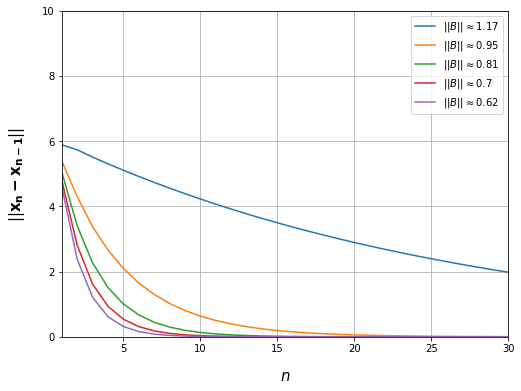

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

n_iter = 50

for j in range(5):
    A_j = A + np.diagflat([j + 3.9]*n)

    x, B, errors = jacobi_iteration(A_j, b, n_iter)

    iterations = np.arange(1, n_iter + 1)
    
    plt.plot(iterations, errors, label=r'$||B|| \approx %s$' % round(np.linalg.norm(B), 2))

#plt.title(r'$||x_n - x_{n-1}||$ v.s. $n$')
plt.ylabel(r'$||\mathbf{x_n - x_{n-1}}||$', size=15, labelpad=15)
plt.xlabel(r'$n$', size=15, labelpad=15)
plt.ylim(0, 10)
plt.xlim(1, 30)
plt.legend()
plt.grid()
plt.show()

# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

In [2]:
def seidel_iteration(A, b, n_iter):

    diag_1d = np.diag(A)
    
    invD = np.diag(1./diag_1d)
    L = np.tril(A, k=-1)
    U = np.triu(A, k=1)
    
    B = invD @ -(L + U)
    
    m = A.shape[0]
    x0 = np.ones(m)
    
    errors = np.zeros(n_iter)
    
    for _ in range(n_iter):
        x = np.zeros(m)
        for i in range(m):
            x[i] = ( b[i] - A[i, :i] @ x[:i] - A[i, i+1:] @ x0[i+1:] ) / A[i, i]
        
        delta_x = np.linalg.norm(x - x0)
        errors[i] = delta_x
        
        x0 = x
    
    return x, B, np.array(errors)

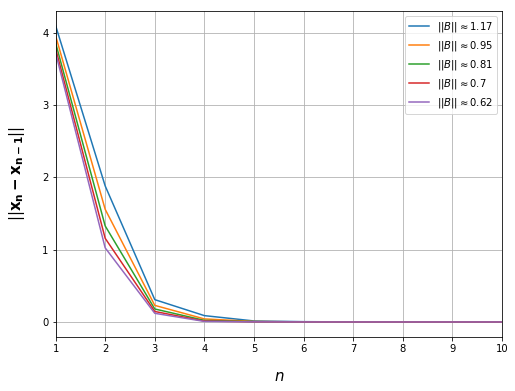

In [37]:
plt.figure(figsize=(8, 6))

n_iter = 50

for j in range(5):
    
    A_j = A + np.diagflat([j+3.9]*n)

    x, B, errors = seidel_iteration(A_j, b, n_iter)

    iterations = np.arange(1, n_iter+1)
    
    plt.plot(iterations, errors, label=r'$||B|| \approx %s$' % round(np.linalg.norm(B), 2))

plt.ylabel(r'$||\mathbf{x_n - x_{n-1}}||$', size=15, labelpad=15)
plt.xlabel(r'$n$', size=15, labelpad=15)
plt.xlim(1, 10)
plt.legend()
plt.grid()
plt.show()

Из графиков зависимости $\|x_n - x_{n-1}\|$ от номера итерации $n$ для разных норм $\|B\|$ итерационной матрицы (набор матриц $A$ один и то же) в случае алгоритма Зейделя видно, что сходимость быстрее, чем в случае алгоритма Якоби, как и ожидалось.

# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

In [38]:
def minimum_residual(A, b, n_iter):
    
    m = A.shape[0]
    
    r = np.zeros((n_iter, m))
    t = np.zeros_like(r)
    
    x0 = np.ones(m)
    
    x_true = np.linalg.solve(A, b)
    dev = np.zeros_like(t)
    
    errors = np.zeros_like(dev)
    
    for j in range(n_iter):
        r[j] = A @ x0 - b
        t[j] = r[j].T @ (A @ r[j]) / np.linalg.norm(A @ r[j])**2
        x = x0 - t[j] * r[j]
        
        dev[j] = np.linalg.norm(x - x_true)
        
        x0 = x
        
    return x, r, t, dev

Проверим, как алгоритм работает для матрицы без доминирующих членов на диагонали.

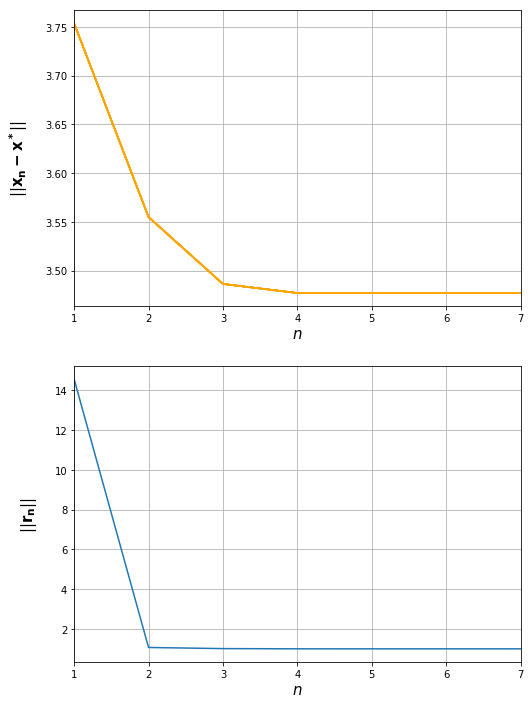

In [39]:
n_iter = 50

x, r, t, dev = minimum_residual(A, b, n_iter)

iterations = np.arange(1, n_iter+1)

f = plt.figure(figsize=[8, 12])
ax1 = f.add_subplot(2, 1, 1)
ax2 = f.add_subplot(2, 1, 2)

ax1.plot(iterations, dev, color='orange')
ax1.set_ylabel(r'$||\mathbf{x_n - x^*}||$', size=15, labelpad=15)
ax1.set_xlabel(r'$n$', size=15, labelpad=2.5)
ax1.set_xlim(1, 7)
#ax1.legend()
ax1.grid()

ax2.plot(iterations, np.linalg.norm(r, axis=1))
ax2.set_ylabel(r'$||\mathbf{r_n}||$', size=15, labelpad=15)
ax2.set_xlabel(r'$n$', size=15, labelpad=2.5)
ax2.set_xlim(1, 7)
#ax2.legend()
ax2.grid()

plt.show()

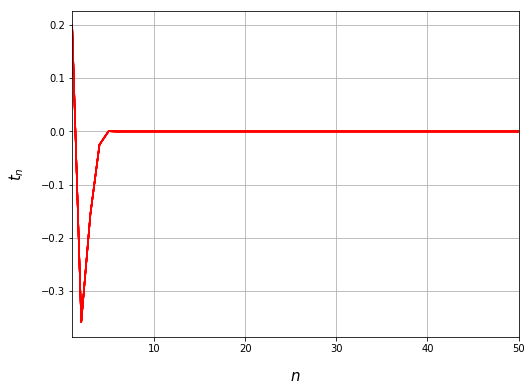

In [40]:
plt.figure(figsize=[8, 6])
plt.plot(iterations, t, color='red')
plt.ylabel(r'$t_n$', size=15, labelpad=15)
plt.xlabel(r'$n$', size=15, labelpad=15)
plt.xlim(1, 50)
plt.grid()
plt.show()

Алгоритм не сошелся, теперь для матрицы с доминирующими членами на диагонали.

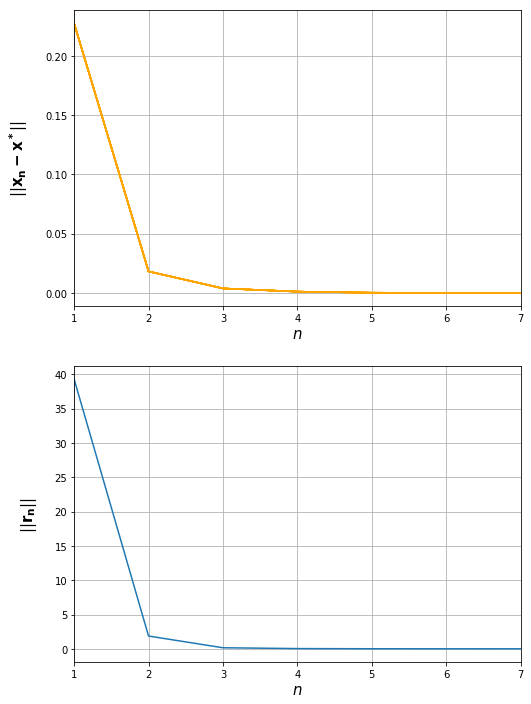

In [41]:
n_iter = 50

x, r, t, dev = minimum_residual(A_j, b, n_iter)

iterations = np.arange(1, n_iter+1)

f = plt.figure(figsize=[8, 12])
ax1 = f.add_subplot(2, 1, 1)
ax2 = f.add_subplot(2, 1, 2)

ax1.plot(iterations, dev, color='orange')
ax1.set_ylabel(r'$||\mathbf{x_n - x^*}||$', size=15, labelpad=15)
ax1.set_xlabel(r'$n$', size=15, labelpad=2.5)
ax1.set_xlim(1, 7)
#ax1.legend()
ax1.grid()

ax2.plot(iterations, np.linalg.norm(r, axis=1))
ax2.set_ylabel(r'$||\mathbf{r_n}||$', size=15, labelpad=15)
ax2.set_xlabel(r'$n$', size=15, labelpad=2.5)
ax2.set_xlim(1, 7)
#ax2.legend()
ax2.grid()

plt.show()

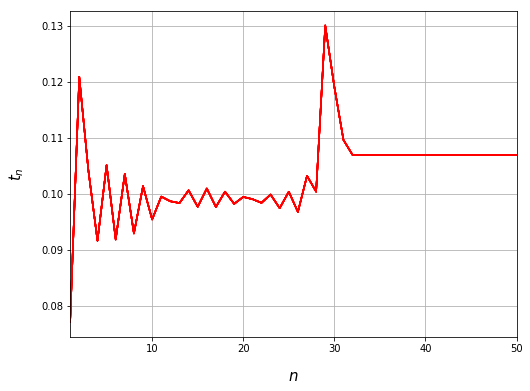

In [42]:
plt.figure(figsize=[8, 6])
plt.plot(iterations, t, color='red')
plt.ylabel(r'$t_n$', size=15, labelpad=15)
plt.xlabel(r'$n$', size=15, labelpad=15)
plt.xlim(1, 50)
plt.grid()
plt.show()

Итерационный параметр $t_n$ изначально осциллирует, затем выходит на константу.

Сравним теперь сходимость трех алгоритмов на матрице с доминирующими элементами на диагонали. 

В алгоритме GMRES:

$$
\| \mathbf{x_n} - \mathbf{x_{n-1}} \| = \|t_{n} \mathbf{r_{n-1}} \|
$$


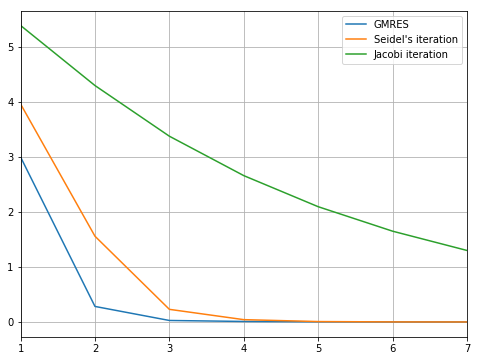

In [43]:
A += np.diagflat([3.9+1]*n)

n_iter = 50

x_mr, r, t, dev = minimum_residual(A, b, n_iter)

errors_mr = np.linalg.norm(r * t, axis=1)

errors_s = seidel_iteration(A, b, n_iter)[2]
errors_j = jacobi_iteration(A, b, n_iter)[2]

plt.figure(figsize=[8, 6])
plt.plot(iterations, errors_mr, label='GMRES')
plt.plot(iterations, errors_s, label="Seidel's iteration")
plt.plot(iterations, errors_j, label='Jacobi iteration')
plt.xlim(1, 7)
plt.legend()
plt.grid()
plt.show()

Для матрицы с доминирующими элементами на диагонали в итоге получилось, что алгоритм GMRES сходится быстрее.